## Linear Model import
Load the MassSpringPD Modelica model, wrap it with SymPy/CasADi helpers, and run Monte Carlo disturbance simulations plus LMI reachable-set bounds.

In [1]:
import sys
from pathlib import Path
import numpy as np

repo_root = None
for path in [Path.cwd().resolve()] + list(Path.cwd().resolve().parents):
    if (path / "cp_reach").exists():
        repo_root = path
        break
if repo_root is None:
    raise RuntimeError("Could not locate repo root")
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Updated imports for new structure
from cp_reach.reachability import (
    sympy_load,
    casadi_load,
    simulate_dist,
    plot_grouped,
    compute_reachable_set,
    plot_flowpipe,
)
from cp_reach.dynamics import classification
import sympy as sp

In [2]:
%load_ext autoreload
%autoreload 2

### Load symbolic model
Build the SymPy backend (with outputs for error dynamics) and classify whether the model and its error dynamics are linear.

In [3]:
# Load SymPy backend (include outputs so error dynamics can be computed)
model_sympy = sympy_load("modelica_models/MassSpringPD.mo", output_names=["e", "ev"])
states = model_sympy.states
inputs = model_sympy.inputs
print("states:", states)
print("inputs:", inputs)

model_type = classification.classify_dynamics(model_sympy)
error_type = classification.classify_error_dynamics(model_sympy)
print("model_type:", model_type)
print("error_type:", error_type)

states: ['x_ref', 'v_ref', 'x', 'v']
inputs: ['u_ff', 'd']
model_type: DynamicsClass.LINEAR
error_type: DynamicsClass.LINEAR


### Simulate with disturbances
Use the CasADi backend to simulate a nominal trajectory and Monte Carlo trials with bounded square-wave disturbances on the `d` input.

In [4]:
# Load CasADi backend
model_casadi = casadi_load("modelica_models/MassSpringPD.mo")

# Nominal ICs (defaults used for any missing states/params)
x0 = {"x": 1, "x_ref": 1}

dist_bound = 1
nom_res, monte_carlo_res = simulate_dist(
    model_casadi,
    x0=x0,
    params=None,
    dist_bound=dist_bound,
    dist_input=["d"],   # disturb the 'd' input
    num_sims=100,
)

### Plot state groups
Overlay nominal and disturbed trajectories for position `x` and velocity `v`.

(<Figure size 800x560 with 2 Axes>,
 array([<Axes: ylabel='x'>, <Axes: xlabel='time', ylabel='v'>],
       dtype=object))

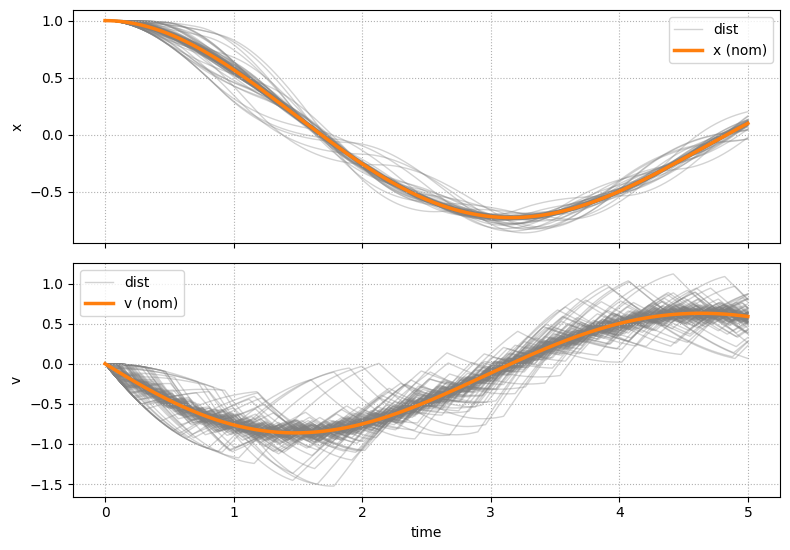

In [5]:
# Plot grouped states
plot_grouped(
    nom_res,
    monte_carlo_res,
    groups=[["x"], ["v"]],
    state_names=model_casadi.state_names,
)

### Compute reachable set via LMI
If the error dynamics are linear, solve the disturbance LMI to obtain P and bounds for the chosen disturbance input.

In [6]:
if error_type == classification.DynamicsClass.LINEAR:
    sol = compute_reachable_set(
        model_sympy,
        method="lmi",
        dynamics="error",
        dist_input = ['d'],
        dist_bound=dist_bound,
        alpha_grid=np.logspace(-4,1,40)
    )
    print(sol)
    print("LMI status:", sol["status"])
    print("gamma:", sol.get("gamma"), "radius_inf:", sol.get("radius_inf"))

{'P': array([[2.96623037, 0.24960221],
       [0.24960221, 1.03168564]]), 'mu': array([2.06552017]), 'cost': 2.0655201673605013, 'alpha': 0.483872609174243, 'prob': Problem(Minimize(Expression(AFFINE, NONNEGATIVE, ())), [PSD(Expression(AFFINE, UNKNOWN, (2, 2))), PSD(Expression(AFFINE, UNKNOWN, (3, 3)))]), 'status': 'optimal', 'radius_inf': 1.4371917642960876, 'bounds_lower': array([-0.84309921, -1.42957659]), 'bounds_upper': array([0.84309921, 1.42957659])}
LMI status: optimal
gamma: None radius_inf: 1.4371917642960876


### Plot flowpipe bound
Wrap the LMI-derived bounds into a time-varying error envelope and plot it with the simulations.

(<Figure size 800x560 with 2 Axes>,
 array([<Axes: ylabel='x'>, <Axes: xlabel='time', ylabel='v'>],
       dtype=object))

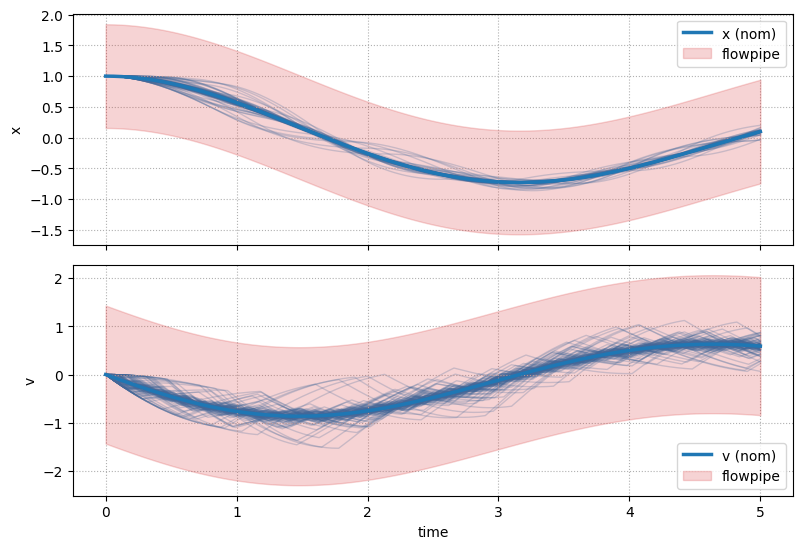

In [7]:
bounds_upper = sol["bounds_upper"]
err_fn = lambda t: bounds_upper
plot_flowpipe(
    nom_res, monte_carlo_res,
    groups=[["x"],["v"]],
    state_names=model_casadi.state_names,
    error_fn=err_fn,
)